In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Model Evaluation 
In previous Chapter testing or Out-of-Sample Data, we covered the differences between validation and testing data. With our model up to this point, we’ve validated during training, but currently have no great way to run a test on data or perform a prediction. To begin, we’re going to add a new evaluate​ ​method to the ​Model​ class:

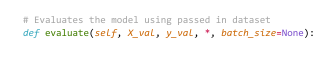

This method takes in samples (​X_val​), target outputs (​y_val​), and an optional batch size. First, we calculate the number of steps given the length of the data and the ​batch_size​ ​argument. This is the same as in the ​train​ method:

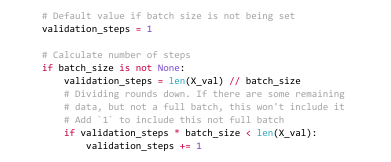
Then, we’re going to move a chunk of code from the ​Model​ class’ ​train​ method:

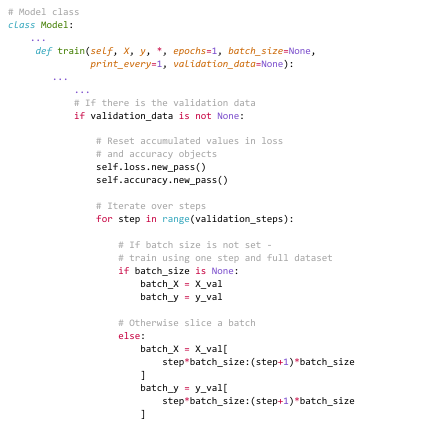

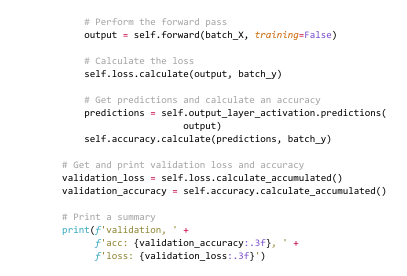.
We’ll move that code, along with the code parts for the number of steps calculation and resetting accumulated loss and accuracy, to the ​evaluate​ method, making it:

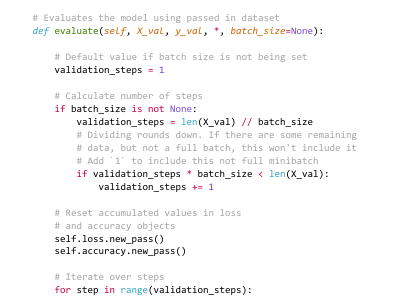

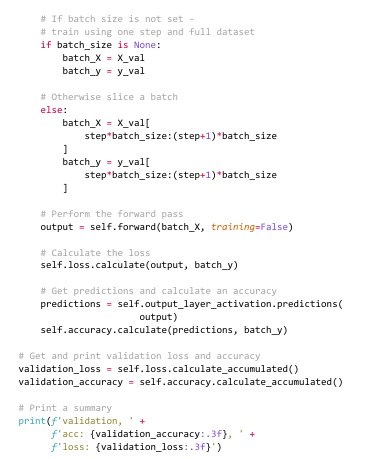

Now, where that block of code once was in the ​Model​ class’ ​train​ method, we can call the new evaluate​ method:

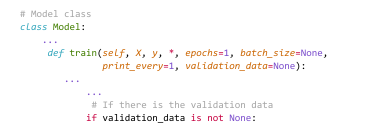

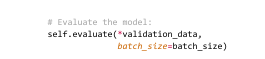

If you’re confused about the ​*​validation_data part, the asterisk, called the ​starred expression​, unpacks the ​validation_data list into singular values. For a simple example of how this works:

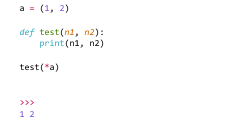
Now that we have this separate ​evaluate​ method, we can evaluate the model whenever we please — either during training or on-demand, by passing the validation or testing data. First, we’ll create and train a model as usual:

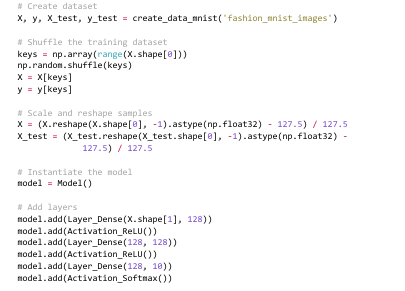

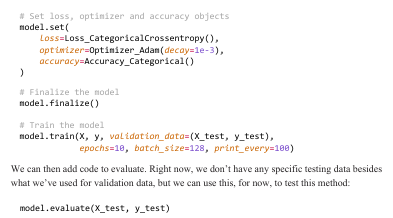

Running this, we get:

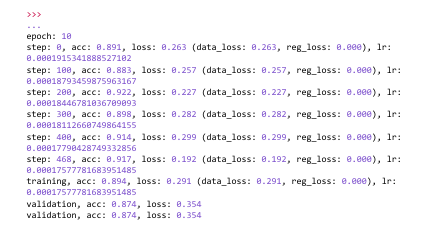

The validation accuracy and loss are repeated twice and show the same values at the end since we’re validating during the training and evaluating right after on the same data. You’ll often train a model, tweak its hyperparameters, train it all over again, and so on, using training and validation data passed into the training method. Then, whenever you find the model and hyperparameters that appear to perform the best, you’ll use that model on testing data and, in the future, to make predictions in production.

Next, we can also run evaluation on the training data:



Running this prints:

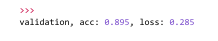


“Validation” here means that we evaluated the model, but we have done this using the training data. We compare that to the result of training on this data which we have just performed:

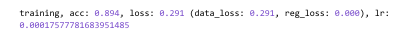

You may notice that, despite using the same dataset, there is some difference between accuracy and loss values. This difference comes from the fact that the model prints accuracy and loss accumulated during the epoch, while the model was still learning; thus, mean accuracy and loss differ from the evaluation on the training data that has been run after the last epoch of training. Running evaluation on the training data at the end of the training process will return the final accuracy and loss. In the next chapter, we will add the ability to save and load our models; we’ll also construct a way to retrieve and set a model’s parameters.








In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Model:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.accuracy = None

        # Initialize lists for performance metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        train_steps = 1

        if batch_size is not None:
            train_steps = X.shape[0] // batch_size
            if train_steps * batch_size < X.shape[0]:
                train_steps += 1

        if validation_data is not None:
            X_val, y_val = validation_data
            validation_steps = 1
            if batch_size is not None:
                validation_steps = X_val.shape[0] // batch_size
                if validation_steps * batch_size < X_val.shape[0]:
                    validation_steps += 1

        for epoch in range(1, epochs + 1):
            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step * batch_size:(step + 1) * batch_size]
                    batch_y = y[step * batch_size:(step + 1) * batch_size]

                # Forward pass
                output = self.forward(batch_X)

                # Loss calculation
                loss = self.loss.calculate(output, batch_y)

                # Backward pass
                self.backward(output, batch_y)

                # Update weights
                self.optimizer.update(self.layers)

                # Track accuracy
                predictions = self.accuracy.predict(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)

            # Store train metrics
            self.train_losses.append(loss)
            self.train_accuracies.append(accuracy)

            # Print training progress
            if not epoch % print_every:
                print(f'Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}')

            # Validation pass
            if validation_data is not None:
                self.loss.new_pass()
                self.accuracy.new_pass()

                for step in range(validation_steps):
                    if batch_size is None:
                        batch_X_val = X_val
                        batch_y_val = y_val
                    else:
                        batch_X_val = X_val[step * batch_size:(step + 1) * batch_size]
                        batch_y_val = y_val[step * batch_size:(step + 1) * batch_size]

                    # Forward pass for validation
                    output_val = self.forward(batch_X_val)

                    # Validation loss
                    loss_val = self.loss.calculate(output_val, batch_y_val)

                    # Track validation accuracy
                    predictions_val = self.accuracy.predict(output_val)
                    accuracy_val = self.accuracy.calculate(predictions_val, batch_y_val)

                # Store validation metrics
                self.val_losses.append(loss_val)
                self.val_accuracies.append(accuracy_val)

                print(f'Validation - Loss: {loss_val}, Accuracy: {accuracy_val}')

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output, y):
        dvalues = self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

    def plot_metrics(self):
        # Plot loss and accuracy
        epochs = range(1, len(self.train_losses) + 1)

        # Loss plot
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        if self.val_losses:
            plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Training Accuracy')
        if self.val_accuracies:
            plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Display plots
        plt.show()



In [3]:
model = Model()
# ... add layers, set loss, optimizer, and accuracy ...

# Train the model
model.train(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Plot the metrics
model.plot_metrics()


NameError: name 'X_train' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

class Model:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.accuracy = None

        # Initialize lists for performance metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.precisions = []
        self.recalls = []
        self.fprs = []  # False positive rates for ROC curve
        self.tprs = []  # True positive rates for ROC curve
        self.auc_scores = []  # Area under the curve for ROC

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        train_steps = 1

        if batch_size is not None:
            train_steps = X.shape[0] // batch_size
            if train_steps * batch_size < X.shape[0]:
                train_steps += 1

        if validation_data is not None:
            X_val, y_val = validation_data
            validation_steps = 1
            if batch_size is not None:
                validation_steps = X_val.shape[0] // batch_size
                if validation_steps * batch_size < X_val.shape[0]:
                    validation_steps += 1

        for epoch in range(1, epochs + 1):
            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step * batch_size:(step + 1) * batch_size]
                    batch_y = y[step * batch_size:(step + 1) * batch_size]

                # Forward pass
                output = self.forward(batch_X)

                # Loss calculation
                loss = self.loss.calculate(output, batch_y)

                # Backward pass
                self.backward(output, batch_y)

                # Update weights
                self.optimizer.update(self.layers)

                # Track accuracy
                predictions = self.accuracy.predict(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)

            # Store train metrics
            self.train_losses.append(loss)
            self.train_accuracies.append(accuracy)

            # Print training progress
            if not epoch % print_every:
                print(f'Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}')

            # Validation pass
            if validation_data is not None:
                self.loss.new_pass()
                self.accuracy.new_pass()

                y_true_val = []
                y_pred_val = []

                for step in range(validation_steps):
                    if batch_size is None:
                        batch_X_val = X_val
                        batch_y_val = y_val
                    else:
                        batch_X_val = X_val[step * batch_size:(step + 1) * batch_size]
                        batch_y_val = y_val[step * batch_size:(step + 1) * batch_size]

                    # Forward pass for validation
                    output_val = self.forward(batch_X_val)

                    # Validation loss
                    loss_val = self.loss.calculate(output_val, batch_y_val)

                    # Track validation accuracy
                    predictions_val = self.accuracy.predict(output_val)
                    accuracy_val = self.accuracy.calculate(predictions_val, batch_y_val)

                    # Collect predictions and ground truths for precision, recall, ROC
                    y_true_val.extend(batch_y_val)
                    y_pred_val.extend(predictions_val)

                # Compute precision, recall, and ROC curve for binary classification
                precision = precision_score(y_true_val, y_pred_val, average='binary')
                recall = recall_score(y_true_val, y_pred_val, average='binary')

                # ROC curve and AUC
                fpr, tpr, _ = roc_curve(y_true_val, y_pred_val)
                roc_auc = auc(fpr, tpr)

                # Store validation metrics
                self.val_losses.append(loss_val)
                self.val_accuracies.append(accuracy_val)
                self.precisions.append(precision)
                self.recalls.append(recall)
                self.fprs.append(fpr)
                self.tprs.append(tpr)
                self.auc_scores.append(roc_auc)

                print(f'Validation - Loss: {loss_val}, Accuracy: {accuracy_val}, Precision: {precision}, Recall: {recall}, AUC: {roc_auc}')

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output, y):
        dvalues = self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

    def plot_metrics(self):
        # Plot loss and accuracy
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(16, 8))

        # Loss plot
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        if self.val_losses:
            plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Training Accuracy')
        if self.val_accuracies:
            plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Precision-Recall plot
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.precisions, label='Precision')
        plt.plot(epochs, self.recalls, label='Recall')
        plt.title('Precision and Recall over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()

        # ROC curve plot
        plt.subplot(2, 2, 4)
        for i, (fpr, tpr) in enumerate(zip(self.fprs, self.tprs)):
            plt.plot(fpr, tpr, label=f'Epoch {i + 1} (AUC = {self.auc_scores[i]:.2f})')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Corrected: Increase n_informative to at least 3 to support 3 classes
X, y = make_classification(n_samples=1000, n_features=20, n_informative=3, 
                           n_classes=3, n_clusters_per_class=2, random_state=42)

# Splitting the dataset into training and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# If you need one-hot encoding for the labels
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))

# Now you can continue with your model implementation and training


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# Dummy Loss class
class Loss:
    def new_pass(self):
        print("Loss new pass")

# Dummy Accuracy class
class Accuracy:
    def new_pass(self):
        print("Accuracy new pass")

# Activation functions
class Activation_Softmax:
    def forward(self, inputs):
        self.output = np.exp(inputs) / np.sum(np.exp(inputs), axis=1, keepdims=True)

class Activation_Softmax_Loss_CategoricalCrossentropy:
    def backward(self, dvalues):
        self.dinputs = dvalues

# Dummy Layer class
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dinputs = np.dot(dvalues, self.weights.T)

# Model class
class Model:
    def __init__(self):
        self.layers = []
        self.loss = Loss()
        self.accuracy = Accuracy()

    def add(self, layer):
        self.layers.append(layer)

    def set_loss(self, loss):
        self.loss = loss

    def set_accuracy(self, accuracy):
        self.accuracy = accuracy

    def forward(self, X):
        for layer in self.layers:
            layer.forward(X)
            X = layer.output
        return X

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        X_val, y_val = validation_data if validation_data else (None, None)
        
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            if validation_data is not None:
                self.loss.new_pass()
                self.accuracy.new_pass()

                validation_steps = len(X_val) // batch_size if batch_size else 1
                for step in range(validation_steps):
                    if batch_size is None:
                        batch_X = X_val
                        batch_y = y_val
                    else:
                        batch_X = X_val[step * batch_size:(step + 1) * batch_size]
                        batch_y = y_val[step * batch_size:(step + 1) * batch_size]
                    
                    # Dummy validation logic
                    print(f"Validation step {step + 1}/{validation_steps}")

# Generating synthetic data for demo purposes
def sine_data(points=1000):
    X = np.linspace(0, 2 * np.pi, points).reshape(-1, 1)
    y = np.sin(X)
    return X, y

# Precision, Recall, ROC Curve plotting
def plot_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f"Precision: {precision}, Recall: {recall}, AUC: {roc_auc}")

    plt.figure(figsize=(14, 7))

    # Plot Precision-Recall
    plt.subplot(1, 2, 1)
    plt.plot(precision, recall, color='blue', label=f'Precision-Recall')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="best")

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='green', label=f'ROC Curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    X, y = sine_data()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Build model
    model = Model()
    model.add(Layer_Dense(1, 64))  # Input layer
    model.add(Layer_Dense(64, 3))  # Output layer

    # Train the model
    model.train(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Fake predictions for demonstration
    y_pred = np.round(np.random.rand(len(y_test)))

    # Plot performance metrics
    plot_performance(y_test, y_pred)


Epoch 1/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 2/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 3/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 4/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 5/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 6/10
Loss new pass
Accuracy new pass
Validation step 1/6
Validation step 2/6
Validation step 3/6
Validation step 4/6
Validation step 5/6
Validation step 6/6
Epoch 7/10
Loss new pa

ValueError: Classification metrics can't handle a mix of continuous and binary targets

Precision: 0.46956521739130436, Recall: 0.54, AUC: 0.465


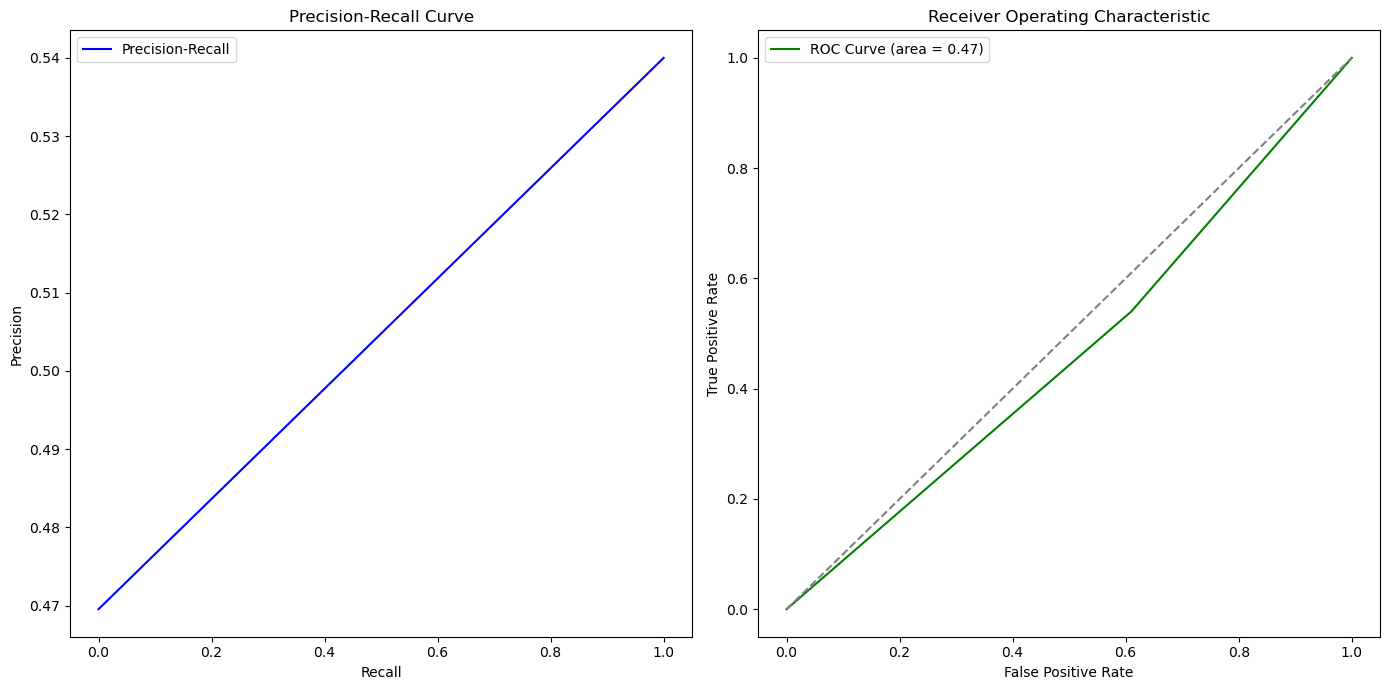

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# Generate sine wave data and convert to binary classification
def sine_data(points=1000):
    X = np.linspace(0, 2 * np.pi, points).reshape(-1, 1)
    y = np.sin(X)
    y = (y > 0).astype(int)  # Convert sine wave to binary classification (1 if > 0, else 0)
    return X, y

# Precision, Recall, ROC Curve plotting
def plot_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f"Precision: {precision}, Recall: {recall}, AUC: {roc_auc}")

    plt.figure(figsize=(14, 7))

    # Plot Precision-Recall
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [precision, recall], color='blue', label=f'Precision-Recall')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="best")

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='green', label=f'ROC Curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

# Model class
class Model:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            layer.forward(X)
            X = layer.output
        return X

    def train(self, X, y, *, epochs=1, batch_size=None, validation_data=None):
        X_val, y_val = validation_data if validation_data else (None, None)
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # For simplicity, training code is omitted

# Dummy Layer class
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

# Example usage
if __name__ == "__main__":
    # Generate binary classification data
    X, y = sine_data()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Build model
    model = Model()
    model.add(Layer_Dense(1, 64))  # Input layer
    model.add(Layer_Dense(64, 1))  # Output layer (binary classification)

    # Fake training and predictions for demonstration
    y_pred = np.round(np.random.rand(len(y_test)))  # Fake predictions for binary classification

    # Plot performance metrics
    plot_performance(y_test, y_pred)


## Saving and Loading Models and Their Parameters 

Retrieving Parameters There are situations where we’d like to take a closer look into model parameters to see if we have dead or exploding neurons. To retrieve these parameters, we will iterate over the trainable layers, take their parameters, and put them into a list. The only trainable layer type that we have here is the ​Dense​ layer. Let’s add a method to the ​Layer_Dense​ class to retrieve parameters:

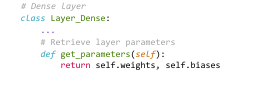

Within the ​Model​ class, we’ll add ​get_parameters​ method, which will iterate over the trainable layers of the model, run their ​get_parameters​ method, and append returned weights and biases to a list:

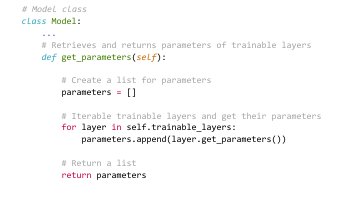

Now, after training a model, we can grab the parameters by running:



This will look ​something​ like (we trim the output to save space):

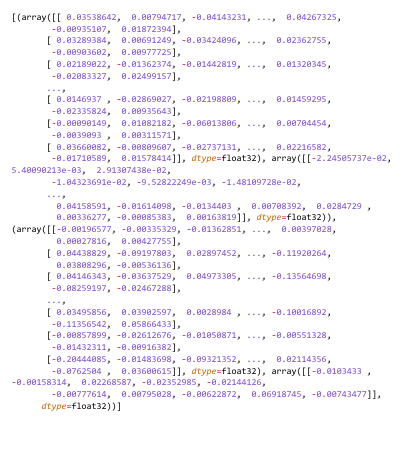

## Setting Parameters 

If we have a method to get parameters, we will likely also want to have a method that will set parameters. We’ll do this similar to how we setup the ​get_parameters​ method, starting with the ​Layer_Dense​ class:

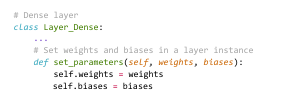

Then we can update the ​Model​ class:

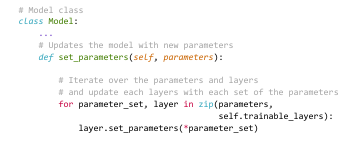

We are also iterating over the trainable layers here, but what we are doing next needs a bit more explanation. First, the ​zip​()​ function takes in iterables, like lists, and returns a new iterable with pairwise combinations of all the iterables passed in as parameters. In other words (and using our example), ​zip​()​ takes a list of parameters and a list of layers and returns an iterator containing tuples of 0th elements of both lists, then the 1st elements of both lists, the 2nd elements from both lists, and so on. This way, we can iterate over parameters and the layer they belong to at the same time. As our parameters are a tuple of weights and biases, we will unpack them with a starred expression so that our ​Layer_Dense​ ​method can take them as separate parameters. This approach gives us flexibility if we’d like to use layers with different numbers of parameter groups.

11 One difference that presents itself now is that this allows us to have a model that never needed an optimizer. If we don’t train a model but, instead, load already trained parameters into it, we won’t optimize anything. To account for this, we’ll visit the ​finalize​ method of the ​Model​ class, changing:

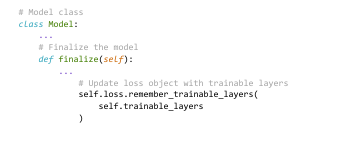

To (we added an ​if​ statement to set a list of trainable layers to the loss function, only if this loss object exists):

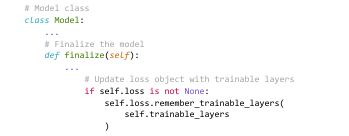

Next, we’ll change the ​Model​ class’ ​set​ method to allow us to pass in only given parameters. We’ll assign default values and add ​if​ statements to use parameters only when they’re present. To do that, we’ll change:

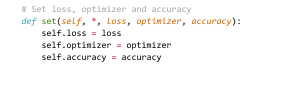

To:

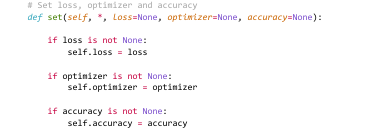

We can now train a model, retrieve its parameters, create a new model, and set its parameters with those retrieved from the previously-trained model:

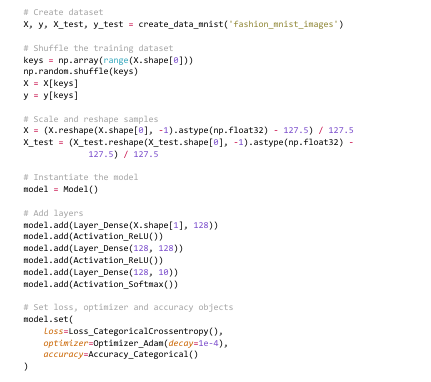

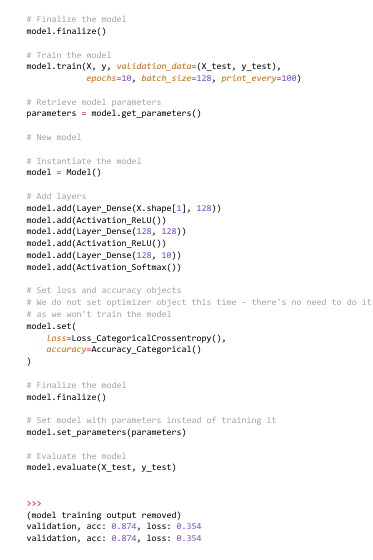

## Saving Parameters 

We’ll extend this further now by actually saving the parameters into a file. To do this, we’ll add a save_parameters​ method in the ​Model​ class. We’ll use Python’s built-in ​pickle​ module to serialize any Python object. Serialization is a process of turning an object, which can be of any abstract form, into a binary representation ​—​ a set of bytes that can be, for example, saved into a file. This serialized form contains all the information needed to recreate the object later. ​Pickle can either return the bytes of the serialized object or save them directly to a file. We’ll make use of the latter ability, so let’s import ​pickle:​

Then we’ll add a new method to the ​Model​ class. Before having ​pickle​ save our parameters into a file, we’ll need to create a file-handler by opening a file in binary-write mode. We will then pass this handler along to the data into ​pickle.dump()​. To create the file, we need a filename that we’ll save the data into; we’ll pass it in as a parameter:

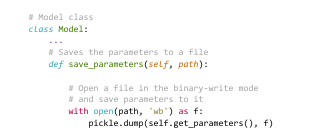

With this method, you can save the parameters of a trained model by running

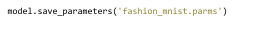



## Loading Parameters 

Presumably, if we are saving model parameters into a file, we would also like to have a way to load them from this file. Loading parameters is very similar to saving the parameters, just reversed. We’ll open the file in a binary-read mode and have ​pickle​ read from it, deserializing parameters back into a list. Then we call the ​set_parameters​ method that we created earlier and pass in the loaded parameters:

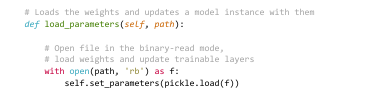

We set up a model, load in the parameters file (we did not train this model), and test the model to check if it works:

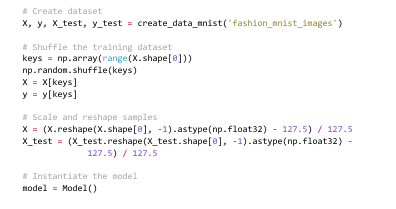

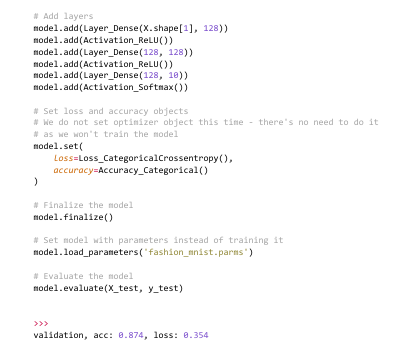

While we can save and load model parameter values, we still need to define the model. It must be the exact configuration as the model that we’re importing parameters from. It would be easier if we could save the model itself.



## Saving the Model 

Why didn’t we save the whole model in the first place? Saving just weights versus saving the whole model has different use cases along with pros and cons. With saved weights, you can, for example, initialize a model with those weights, trained from similar data, and then train that model to work with your specific data. This is called ​transfer learning​ and is outside of the scope of this book. Weights can be used to visualize the model (like in some animations that we have created for the purpose of this book, starting from chapter 6), identify dead neurons, implement more complicated models (like ​reinforcement learning​, where weights collected from multiple models are committed to a single network), and so on. A file containing just weights is also much smaller than an entire model. A model initialized from weights loads faster and uses less memory, as the optimizer and related parts are not created. One downside of loading just weights and biases is that the initialized model does not contain the optimizer’s state. It is possible to train the model further, but it’s more optimal to load a full model if we intend to train it. When saving the full model, everything related to it is saved as well; this includes the optimizer’s state (that allows us to easily continue the training) and model’s structure. We’ll create another method in the ​Model​ class that we’ll use to save the entire model. The first thing we’ll do is make a copy of the model since we’re going to edit it before saving, and we may also want to save a model during the training process as a ​checkpoint​.

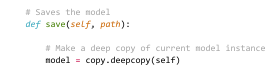

We import the ​copy ​module to support this:
The ​copy​ module offers two methods that allow us to copy the model — ​copy​ and ​deepcopy​. While ​copy​ is faster, it only copies the first level of the object’s properties, causing copies of our model objects to have some references common to the original model. For example, our model object has a list of layers — the list is the top-level property, and the layers themselves are secondary — therefore, references to the layer objects will be shared by both the original and copied model objects. Due to these challenges with ​copy,​ ​ w ​ e’ll use the ​deepcopy​ method to recursively traverse all objects and create a full copy.

Next, we’ll remove the accumulated loss and accuracy:

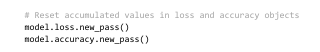

Then remove any data in the input layer, and reset the gradients, if any exist:

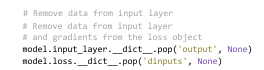

Both ​model.input_layer​ and ​model.loss​ are class instances. They’re attributes of the Model​ object but also objects themselves. One of the dunder properties (called “dunder” because of the double underscores) that exists for all classes is the ​__dict__​ property. It contains names and values for the class object’s properties. We can then use the built-in ​pop​ method on these values, which means we remove them from that instance of the class’ object. The ​pop​ method will wind up throwing an error if the key we pass as the first parameter doesn’t exist, as the ​pop method wants to return the value of the key that it removes. We use the second parameter of the pop​ method ​— ​which is the default value that we want to return if the key doesn’t exist ​— ​to prevent these errors. We will set this parameter to ​None​ — we do not intend to catch the removed values, and it doesn’t really matter what the default value is. This way, we do not have to check if a given property exists, in times like when we’d like to delete it using the ​del​ statement, and some of them might not exist.

Next, we’ll iterate over all the layers to remove their properties:

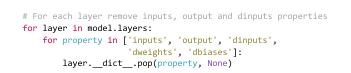

With these things cleaned up, we can save the model object. To do that, we have to open a file in a binary-write mode, and call ​pickle.dump()​ with the model object and the file handler as parameters:

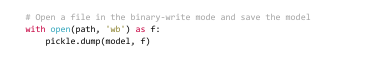

This makes the full ​save​ method:

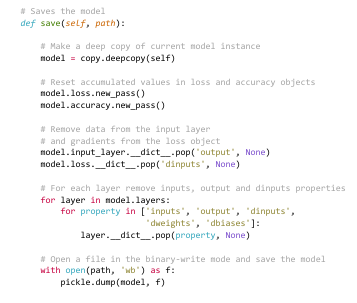

This means we can train a model, then save it whenever we wish with:

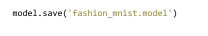




## Loading the Model 

Loading a model will ideally take place before a model object even exists. What we mean by this is we could load a model by calling a method of the ​Model​ class instead of the object:



To achieve this, we’re going to use the ​@​staticmethod​ d​ ecorator. This decorator can be used with class methods to run them on uninitialized objects, where the ​self​ does not exist (notice that it is missing the function definition). In our case, we’re going to use it to immediately create a model object without first needing to instantiate a model object. Within this method, we’ll open a file using the passed-in path, in binary-read mode, and use pickle to deserialize the saved model:

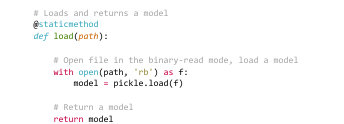

Since we already have a saved model, let’s create the data, and then load a model to see if it works:

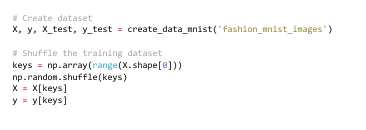

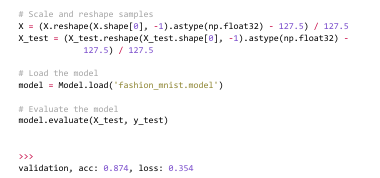

Saving the full trained model is a common way of saving a model. It saves parameters (weights and biases) and instances of all the model’s objects and the data they generated. That is going to be, for example, the optimizer state like cache, learning rate decay, full model structure, etc. Loading the model, in this case, is as easy as calling one method and the model is ready to use, whether we want to continue training it or use it for a prediction.

